In [302]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [303]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [304]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    # linux
]

used_test_case_names = [
    # 'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]
used_compilers = [
    'intel-one-api'
]

test_case_parameters = ["", "12", "16000", "64000"]

experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
experiment_number = 2

used_allocated_cores.sort()
used_mi_names.sort()
used_compilers.sort()

In [305]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)
dut = rep.get_devices_under_test(db)
dut.shape

(7, 4)

In [306]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")
used_dut.shape

(1, 4)

In [307]:
tc = rep.get_test_cases(db)
tc.shape

(30, 8)

In [308]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [309]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [310]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [311]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

In [312]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [313]:
config = rep.get_configurations(db)

config.shape

(15, 5)

In [314]:
config.shape

(15, 5)

In [315]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [316]:
exp = rep.get_distinct_experiments(db)

exp.shape

(7, 2)

In [317]:
for i in range(0, 1001, 100):
    print(i)

0
100
200
300
400
500
600
700
800
900
1000


In [318]:
data_to_plot = {}

for i in range(100, 1001, 100):
    print(i)
    cpu_energy_results = {}
    dram_energy_results = {}
    gpu_energy_results = {}
    duration_results = {}

    idle_cpu_consumption_results = {}

    cpu_dynamic_energy_watt_consumption = {}

    cpu_dynamic_energy_consumption = {}
    gpu_dynamic_energy_consumption = {}
    dram_dynamic_energy_consumption = {}

    temperature_begin = {}
    temperature_end = {}

    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption
    )
    
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_consumption.keys():
        data_to_plot[k + "." +str(i).rjust(5, '0')] = cpu_dynamic_energy_consumption[k]

100
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
200
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
300
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
400
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
500
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
600
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.22
700
N - mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.100.5
Y - mandelbrot.exe.win32nt.wor

In [319]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [320]:
data_to_plot = convert_to_series(data_to_plot)
data_df = pd.DataFrame(data_to_plot)
data_df = data_df.reindex(columns=sorted(data_df.columns))

Duration of Test Case


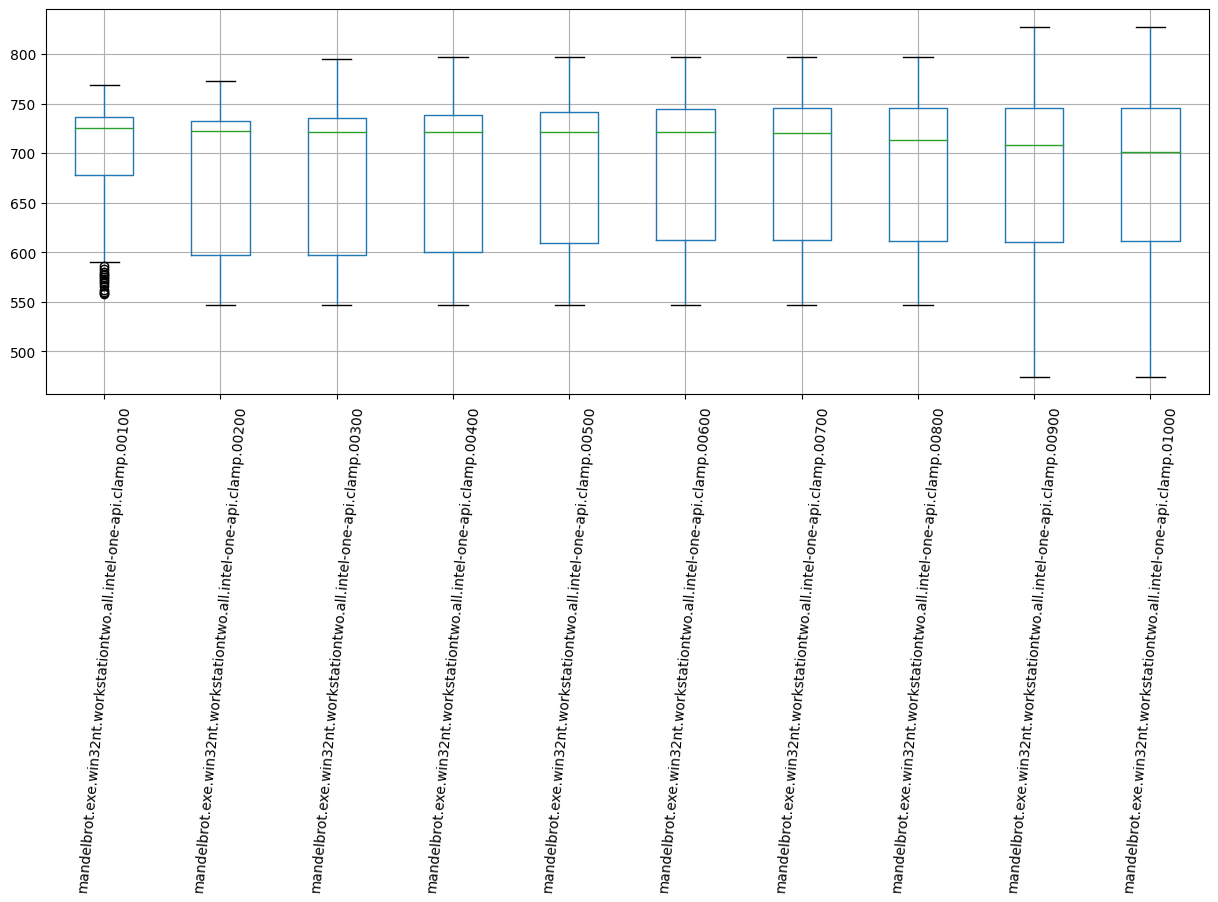

In [326]:
print("Duration of Test Case")
boxplot = data_df.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
# plot.ylim(0,1300)
plot.show()

In [322]:
data_df

,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00100,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00200,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00300,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00400,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00500,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00600,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00700,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00800,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.00900,mandelbrot.exe.win32nt.workstationtwo.all.intel-one-api.clamp.01000
0,768.902404,768.902404,768.902404,768.902404,768.902404,768.902404,768.902404,768.902404,768.902404,768.902404
1,764.666816,764.666816,764.666816,764.666816,764.666816,764.666816,764.666816,764.666816,764.666816,764.666816
2,731.823786,731.823786,731.823786,731.823786,731.823786,731.823786,731.823786,731.823786,731.823786,731.823786
3,748.364808,748.364808,748.364808,748.364808,748.364808,748.364808,748.364808,748.364808,748.364808,748.364808
4,745.860801,745.860801,745.860801,745.860801,745.860801,745.860801,745.860801,745.860801,745.860801,745.860801
...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.353338
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,603.755788
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,768.661757
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,616.989145


In [323]:

_, box_plot_data = data_df.boxplot(return_type="both")
medians = [median.get_ydata() for median in box_plot_data["medians"]]

In [324]:
medians

[array([725.69093226, 725.69093226]),
 array([722.85832471, 722.85832471]),
 array([720.94837105, 720.94837105]),
 array([721.31561951, 721.31561951]),
 array([721.0005528, 721.0005528]),
 array([721.0005528, 721.0005528]),
 array([720.85131745, 720.85131745]),
 array([713.32472107, 713.32472107]),
 array([708.70596667, 708.70596667]),
 array([701.50533364, 701.50533364])]

In [333]:
first_median = medians[0][0]
second_last_median = medians[-2][0]
last_median = medians[-1][0]

In [334]:
first_median, last_median, second_last_median

(725.6909322637096, 701.5053336410954, 708.7059666664006)

In [337]:
(last_median / first_median) * 100

96.66723152414623

In [327]:
box_plot_raw_data = [
    {
        "data" : data_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 900,
        "xlabel" : "Total Energy Consumption (Joules)"
    }
]

In [329]:
for plot_data in box_plot_raw_data:
    print("start")
    data = plot_data["data"]
    width = plot_data["width"]
    height = 0.1 + (len(data.columns) * 0.02)
    xmin = plot_data["xmin"]
    xmax = plot_data["xmax"]
    xlabel = plot_data["xlabel"]
    
    latex_boxes = tex.get_boxes(data)
    plot.clf()
    # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
    
    title = f"The evolution of energy consumption"
    
    
    ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
    
    yticklables = [
        '100',
        '200',
        '300',
        '400',
        '500',
        '600',
        '700',
        '800',
        '900',
        '1000'
    ]
    
    labels = f"evolution_of_medians".lower()
    
    caption = "A visual representation of how the energy measurements evolve as more measurements are made by clamp on DUT 2 for test case MB"
    
    latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

    box_plot_path = f"evolution"
    box_plot_file_name = f"evolution.tex"
    print(f"generating {box_plot_file_name}")
    # print(data)
    path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)

start
generating evolution.tex
